In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import copy
from matplotlib.patches import Ellipse

In [2]:
# Data preparation

data1 = np.loadtxt('data/synthetic1.data', delimiter=',')
X1= data1[:,0:2]
y1=data1[:,2]

data2 = load_iris()
X2= data2.data
y2 = data2.target

data3 = load_wine()
X3 = data3.data
y3 = data3.target

# Split train and test datasets

X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.3,
                                                     random_state=42,stratify=y1)
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size=0.3,
                                                     random_state=42,stratify=y2)
X3_train,X3_test,y3_train,y3_test = train_test_split(X3,y3,test_size=0.3,
                                                     random_state=42,stratify=y3)

### Funtion for Knn based denoising

In [3]:
def denoise_by_knn(X,y,k,xi):
    
    indices_to_remove = []
    
    for i in  range(X.shape[0]):
        nearest_points=[]
        distances =[]
        
        # Calculate the distance of the test point from all the points in training set.
        for j in range(X.shape[0]):
            distance = np.linalg.norm(X[j]-X[i])
            distances.append((distance,j))
        
        #Sort the list and find first k neighbours
        distances.sort(key=lambda x: x[0])
        
        labels = np.zeros(k)
        for n in range(k):
            nearest_points.append(distances[n])
            labels[n] = y[distances[n][1]]
        
        unique_elements, counts_elements = np.unique(labels, return_counts=True)
        
        l = counts_elements.shape[0]
        
        majority_class = 0
        majority_count = 0
        for m in range(l):
            if(counts_elements[m] > majority_count):
                majority_count = counts_elements[m]
                majority_class = unique_elements[m]
        
        ignore = True
        if(majority_class == y[i] and majority_count >= xi):
            ignore = False
              
        if(ignore):
            indices_to_remove.append(i)
    
    # Remove the samples for which there is no class having the count of labels >= xi
    if(len(indices_to_remove) > 0):
        X_denoised = np.delete(X,indices_to_remove,0)
        y_denoised = np.delete(y,indices_to_remove)
    else:
        X_denoised = np.copy(X)
        Y_denoised = np.copy(y)
    
    return X_denoised,y_denoised

### Function for Pca based denoising

In [4]:
def aniso_dist2(Xc,s,VT,C):
    """ Measure anisotropic distances for data points in a class """
    AD2 = []
    N,d = Xc.shape
    for i in range(N):
         AD2.append( sum(((Xc[i]-C).dot(VT[j])/s[j])**2 for j in range(d)) )
    return np.array(AD2)

In [5]:
def denoise_by_pca(X,y,p):
    X_list = []
    y_list = []
    nclass = len(np.unique(y))
    for c in range(nclass):
        indices_to_remove =[]
        Xc = X[y==c]
        yc = y[y==c]
        CC = np.mean(Xc,axis=0)
        U,s,VT = np.linalg.svd(Xc-CC,full_matrices=False)
        AD2 = aniso_dist2(Xc,s,VT,CC)
        r_max_squared = np.amax(AD2)
        
        sortIndex = np.argsort(AD2)
        Xcs = Xc[sortIndex]
        
        N = round(p*Xc.shape[0])
        X_list.append(Xcs[:N])
        y_list.append(yc[:N])

        
    X_denoised = np.vstack((X_list))
    y_denoised = np.hstack((y_list))
    
    return X_denoised,y_denoised

## Lets see the changes in Synthetic dataset by denoising the data.

In [57]:
# Denoise the dataset based on knn
X1_denoised_knn,y1_denoised_knn = denoise_by_knn(X1_train,y1_train,5,4)

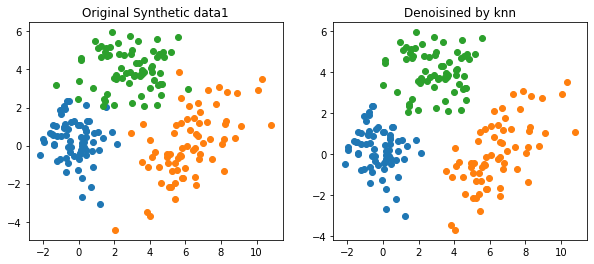

In [7]:
# Plot the graphs to see the differences

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))

    
ax[0].scatter(X1_train[y1_train==0,0],X1_train[y1_train==0,1])
ax[0].scatter(X1_train[y1_train==1,0],X1_train[y1_train==1,1])
ax[0].scatter(X1_train[y1_train==2,0],X1_train[y1_train==2,1])
ax[0].set_title('Original Synthetic data1')

ax[1].scatter(X1_denoised_knn[y1_denoised_knn==0,0],
              X1_denoised_knn[y1_denoised_knn==0,1])
ax[1].scatter(X1_denoised_knn[y1_denoised_knn==1,0],
              X1_denoised_knn[y1_denoised_knn==1,1])
ax[1].scatter(X1_denoised_knn[y1_denoised_knn==2,0],
              X1_denoised_knn[y1_denoised_knn==2,1])
ax[1].set_title('Denoisined by knn')

plt.show()

From the above plots we can see that the clusters are well separated by denoising the data

In [58]:
# Denoise the dataset based on Pca
X1_denoised_pca,y1_denoised_pca = denoise_by_pca(X1_train,y1_train,0.9)

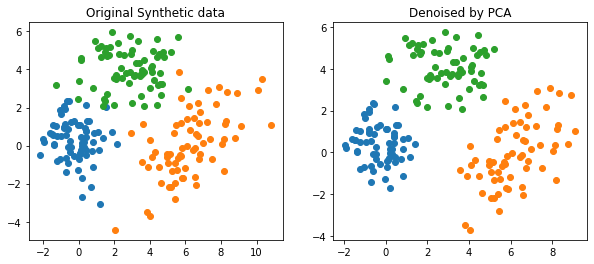

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4)
                     )

ax[0].scatter(X1_train[y1_train==0,0],X1_train[y1_train==0,1])
ax[0].scatter(X1_train[y1_train==1,0],X1_train[y1_train==1,1])
ax[0].scatter(X1_train[y1_train==2,0],X1_train[y1_train==2,1])
ax[0].set_title('Original Synthetic data')

ax[1].scatter(X1_denoised_pca[y1_denoised_pca==0,0],
              X1_denoised_pca[y1_denoised_pca==0,1])
ax[1].scatter(X1_denoised_pca[y1_denoised_pca==1,0],
              X1_denoised_pca[y1_denoised_pca==1,1])
ax[1].scatter(X1_denoised_pca[y1_denoised_pca==2,0],
              X1_denoised_pca[y1_denoised_pca==2,1])
ax[1].set_title('Denoised by PCA')

plt.show()

From the above plots we can see the clusters are well separated now.

### Plot the MVEE

In [10]:
COLOR = ['r','b','c']
MARKER = ['.','s','+','*']

def VT2angle(VT):
    return np.arccos(np.abs(VT[0,0])) *(180/np.pi);

def dataCellipses(X,y,savename):
    
    N,d = X.shape; nclass = len(set(y))
    if d==2:  #for figures
        ELL = [];
        #fig, p = plt.subplots()  #Open new plots
        p = plt.subplot(111)      #Reuse instances
    for c in range(nclass):
        Xc = X[y==c]; CC = np.mean(Xc,axis=0)
        U, s, VT = np.linalg.svd(Xc-CC,full_matrices=False)
        AD2 = aniso_dist2(Xc,s,VT,CC)
        if d==2: #for figures
            plt.scatter(Xc[:,0],Xc[:,1],s=15,c=COLOR[c])
            angle = VT2angle(VT);
            eta = np.sqrt(max(AD2))*2
            ELL.append(Ellipse(CC, s[0]*eta, s[1]*eta, angle ) )

    if d==2:  #for figures
        for c, e in enumerate(ELL):
            e.set_clip_box(p.bbox); e.set_alpha(0.33)
            e.set_facecolor(COLOR[c])
            p.add_artist(e)
        #ymin,ymax = np.min(X[:,1]), np.max(X[:,1])
        #plt.ylim([int(ymin)-1,int(ymax)+1])
        plt.title('MVEE')
        plt.show(block=False); plt.pause(5)

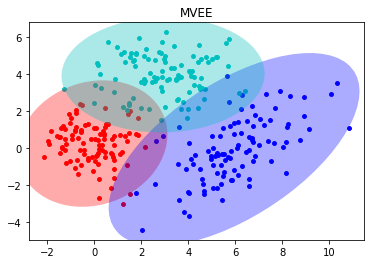

In [11]:
dataCellipses(X1,y1,'Synthetic Data1')


The above plot shows the minimum volume enclosing ellipsoid(MVEE)

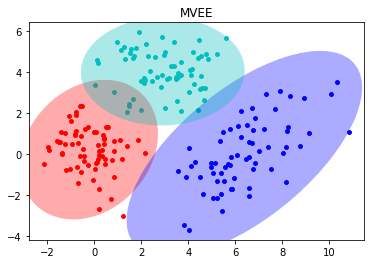

In [12]:
dataCellipses(X1_denoised_knn,y1_denoised_knn,"Denoisedby knn")

The above plot shows the MVEE of the denoised dataset. We can see that the overlapping regions have reduced a lot and the clusters are well separated.

### Run the experiments for different datasets

In [13]:
datasets = [X1,X2,X3]
data_names = ['Synthetic Data','Iris Data','Wine Data']
labels = [y1,y2,y3]
classifiers = [LogisticRegression(max_iter=10000),
               KNeighborsClassifier(5),SVC(gamma=2,C=1),
               RandomForestClassifier(max_depth=5,
                                      n_estimators=50,max_features=1)]
classifier_names = ['Logistic Regression','KNeighbors classifier',
                   'SVM','Random Forest']
k=5
xi=4
p=0.75

for i in range(len(datasets)):
    X_train,X_test,y_train,y_test = train_test_split(datasets[i],labels[i],
                                                     test_size=0.3,
                                                     random_state=42,
                                                     stratify=labels[i])
    
    X_denoised_Byknn,y_denoised_Byknn = denoise_by_knn(X_train,y_train,k,xi)
    X_denoised_ByPca,y_denoised_ByPca = denoise_by_pca(X_train,y_train,p)
    
    print('{} {:<20} {:<17} {:<14} {:<14}'.format('Accuracies for',
                                                  data_names[i],'Before denoising',
                                                  'KNN-denoising','PCA-denoising'))
    
    for j in range(len(classifiers)):
        
        clf = classifiers[j]
        clf_denoisedKnn = clone(classifiers[j])
        clf_denoisedPca = clone(classifiers[j])
        
        clf.fit(X_train,y_train)
        clf_denoisedKnn.fit(X_denoised_Byknn,y_denoised_Byknn)
        clf_denoisedPca.fit(X_denoised_ByPca,y_denoised_ByPca)
        
        score = clf.score(X_test,y_test)
        score_denoisedKnn = clf_denoisedKnn.score(X_test,y_test)
        score_denoisedPca = clf_denoisedPca.score(X_test,y_test)
        
        print('{:<40} {:<17.5f} {:<14.5f} {:<14.5f}'.format(classifier_names[j],
                                                            score,score_denoisedKnn,
                                                            score_denoisedPca))
    print('\n')
        

Accuracies for Synthetic Data       Before denoising  KNN-denoising  PCA-denoising 
Logistic Regression                      0.94444           0.94444        0.96667       
KNeighbors classifier                    0.93333           0.93333        0.96667       
SVM                                      0.93333           0.94444        0.92222       
Random Forest                            0.95556           0.93333        0.93333       


Accuracies for Iris Data            Before denoising  KNN-denoising  PCA-denoising 
Logistic Regression                      0.93333           0.93333        0.95556       
KNeighbors classifier                    0.97778           0.95556        0.97778       
SVM                                      0.97778           0.97778        0.97778       
Random Forest                            0.88889           0.86667        0.93333       


Accuracies for Wine Data            Before denoising  KNN-denoising  PCA-denoising 
Logistic Regression             

From the above results we can see that the accuracies of the datasets have slightly increased and remained the same in some other cases. It is also observed that the accuracies of pca-based denoised datasets is better than the knn-based denoised datasets.

### run_experiments defined below is the function that runs the experiments for different parameter values depending upon the method selected for denoising

In [14]:
def run_experiments(X,y,data_name,classifiers,classifier_names,method,parameters,k=5):
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                     random_state=42,stratify=y)

    accuracies_before_denoising = []

    knn_classifiers = copy.deepcopy(classifiers)
    pca_classifiers = copy.deepcopy(classifiers)
    
    for i in range(len(classifiers)):
        
        for j in range(len(classifiers)):
            clf = classifiers[j]
            clf.fit(X_train,y_train)
            accuracies_before_denoising.append(clf.score(X_test,y_test))
    
        
    print("For ",data_name ,':-')
    print('\n')
    if(method == 'knn'):
        
        for i in range(len(parameters)):
            X_denoised,y_denoised = denoise_by_knn(X_train,y_train,k,parameters[i])
            
            print('{:<40}{:<22}{:<18}{}'.format('Classifiers','Before Denoising',
                                                'knn-denoising xi =',parameters[i]))
            
            for j in range(len(classifiers)):
                clf_knn = knn_classifiers[j]
                clf_knn.fit(X_denoised,y_denoised)
                score = clf_knn.score(X_test,y_test)
                print('{:<40}{:10.5f}{:22.5f}'.format(classifier_names[j],
                                                      accuracies_before_denoising[j],
                                                      score))
            print('\n')
        
    if(method == 'pca'):
        
        for i in range(len(parameters)):
            X_denoised,y_denoised = denoise_by_pca(X_train,y_train,parameters[i])
            
            print('{:<40}{:<22}{:<18}{}'.format('Classifiers','Before Denoising',
                                                'pca-denoising p=',parameters[i]))
            
            for j in range(len(classifiers)):
                clf_pca = pca_classifiers[j]
                clf_pca.fit(X_denoised,y_denoised)
                score = clf_pca.score(X_test,y_test)
                print('{:<40}{:10.5f}{:22.5f}'.format(classifier_names[j],
                                                      accuracies_before_denoising[j],score))
            print('\n')


## For Synthetic Dataset

In [15]:
xi_values = [4,3]
run_experiments(X1,y1,data_names[0],classifiers,classifier_names,method='knn',
                parameters=xi_values)

For  Synthetic Data :-


Classifiers                             Before Denoising      knn-denoising xi =4
Logistic Regression                        0.94444               0.94444
KNeighbors classifier                      0.93333               0.93333
SVM                                        0.93333               0.94444
Random Forest                              0.92222               0.93333


Classifiers                             Before Denoising      knn-denoising xi =3
Logistic Regression                        0.94444               0.94444
KNeighbors classifier                      0.93333               0.93333
SVM                                        0.93333               0.94444
Random Forest                              0.92222               0.95556




For both values of xi , accuracies have improved slightly for SVM and RandomForestClassifier.

In [16]:
xi_values = [5,4]
run_experiments(X1,y1,data_names[0],classifiers,classifier_names,
                method='knn',parameters=xi_values,k=6)

For  Synthetic Data :-


Classifiers                             Before Denoising      knn-denoising xi =5
Logistic Regression                        0.94444               0.94444
KNeighbors classifier                      0.93333               0.93333
SVM                                        0.93333               0.94444
Random Forest                              0.92222               0.94444


Classifiers                             Before Denoising      knn-denoising xi =4
Logistic Regression                        0.94444               0.93333
KNeighbors classifier                      0.93333               0.93333
SVM                                        0.93333               0.94444
Random Forest                              0.92222               0.94444




In [17]:
xi_values = [2]
run_experiments(X1,y1,data_names[0],classifiers,classifier_names,
                method='knn',parameters=xi_values,k=3)

For  Synthetic Data :-


Classifiers                             Before Denoising      knn-denoising xi =2
Logistic Regression                        0.94444               0.94444
KNeighbors classifier                      0.93333               0.93333
SVM                                        0.93333               0.94444
Random Forest                              0.94444               0.94444




From the above experiments we can see that changing the values of k and xi in the denoising method does not affect the accuracies of the algorithms. All the accuracies are around 93-94%

In [18]:
p_values = [0.75,0.9]
run_experiments(X1,y1,data_names[0],classifiers,classifier_names,
                method='pca',parameters=p_values)

For  Synthetic Data :-


Classifiers                             Before Denoising      pca-denoising p=  0.75
Logistic Regression                        0.94444               0.96667
KNeighbors classifier                      0.93333               0.96667
SVM                                        0.93333               0.92222
Random Forest                              0.93333               0.95556


Classifiers                             Before Denoising      pca-denoising p=  0.9
Logistic Regression                        0.94444               0.92222
KNeighbors classifier                      0.93333               0.94444
SVM                                        0.93333               0.94444
Random Forest                              0.93333               0.96667




We can see the the accuracies before denoising and after denoising have slightly increased or reamined almost the same. Only in 2 cases it came little down. We can say that denoising does make a slight improvement in the accuracy for this dataset.

By comparing the above results , we casn chose the Kneighbors classifier or Logistic regression by the method of PCA denoising. Lets try to tune the classifiers further to see which one is better.

Logistic regression does not have any much important hyperparamter. So lets try to tune the Knn algorithm with different values for k


In [19]:
knn6 = KNeighborsClassifier(6)
knn3 = KNeighborsClassifier(3)

In [20]:
X1_denoised_pca,y1_denoised_pca = denoise_by_pca(X1_train,y1_train,0.75)

In [21]:
knn6.fit(X1_denoised_pca,y1_denoised_pca)
knn3.fit(X1_denoised_pca,y1_denoised_pca)
print('knn6 score = ',knn6.score(X1_test,y1_test))
print('knn3 score = ',knn3.score(X1_test,y1_test))

knn6 score =  0.9555555555555556
knn3 score =  0.9666666666666667


We havent found any better accuracy from the above the results of experimentation.

### Hence the best chosen models for Synthetic data1 are Logistic Regression and KNeighbors classifier(5) with PCA based denoising ( p = 0.75) which give the accuracy of about 96.67%

## For Iris Data

In [22]:
xi_values = [4,3]
run_experiments(X2,y2,data_names[1],classifiers,classifier_names,
                method='knn',parameters=xi_values)

For  Iris Data :-


Classifiers                             Before Denoising      knn-denoising xi =4
Logistic Regression                        0.93333               0.93333
KNeighbors classifier                      0.97778               0.95556
SVM                                        0.97778               0.97778
Random Forest                              0.91111               0.91111


Classifiers                             Before Denoising      knn-denoising xi =3
Logistic Regression                        0.93333               0.95556
KNeighbors classifier                      0.97778               0.97778
SVM                                        0.97778               0.95556
Random Forest                              0.91111               0.91111




In [23]:
xi_values = [5,4]
run_experiments(X2,y2,data_names[1],classifiers,classifier_names,
                method='knn',parameters=xi_values,k=6)

For  Iris Data :-


Classifiers                             Before Denoising      knn-denoising xi =5
Logistic Regression                        0.93333               0.93333
KNeighbors classifier                      0.97778               0.95556
SVM                                        0.97778               0.97778
Random Forest                              0.91111               0.91111


Classifiers                             Before Denoising      knn-denoising xi =4
Logistic Regression                        0.93333               0.95556
KNeighbors classifier                      0.97778               0.97778
SVM                                        0.97778               0.97778
Random Forest                              0.91111               0.91111




In [24]:
xi_values = [2]
run_experiments(X2,y2,data_names[1],classifiers,classifier_names,
                method='knn',parameters=xi_values,k=3)

For  Iris Data :-


Classifiers                             Before Denoising      knn-denoising xi =2
Logistic Regression                        0.93333               0.95556
KNeighbors classifier                      0.97778               0.97778
SVM                                        0.97778               0.95556
Random Forest                              0.88889               0.93333




Here also we can see that the accuracies have not been affected by changing the k and xi values for denoising.

In [25]:
p_values = [0.75,0.9]
run_experiments(X2,y2,data_names[1],classifiers,classifier_names,
                method='pca',parameters=p_values)

For  Iris Data :-


Classifiers                             Before Denoising      pca-denoising p=  0.75
Logistic Regression                        0.93333               0.95556
KNeighbors classifier                      0.97778               0.97778
SVM                                        0.97778               0.97778
Random Forest                              0.91111               0.91111


Classifiers                             Before Denoising      pca-denoising p=  0.9
Logistic Regression                        0.93333               0.95556
KNeighbors classifier                      0.97778               0.97778
SVM                                        0.97778               0.95556
Random Forest                              0.91111               0.91111




For Iris data , we can see that here also only in 2 cases the accuracy went down a little bit. But in all other cases the accuracy improved or stayed the same.

For Iris data , knn and pca denoising both gives accuracy of 97.78%. lets try if the hypertuning of parameters increases the accuracy by little. In Knn we can chose a different k and in SVM we can chose gamma and C values.

In [26]:
classifiers_iris = [KNeighborsClassifier(3),SVC(gamma=1,C=1),SVC(gamma=1,C=10)]
classifier_iris_names = ['Knn(3)','SVM gamma=1,C=1','SVM gamma=1,C=10']

In [27]:
run_experiments(X2,y2,data_names[1],classifiers_iris,classifier_iris_names,
                method='knn',parameters=xi_values)

For  Iris Data :-


Classifiers                             Before Denoising      knn-denoising xi =2
Knn(3)                                     0.95556               0.97778
SVM gamma=1,C=1                            0.95556               0.95556
SVM gamma=1,C=10                           0.97778               0.95556




In [28]:
p_values = [0.75,0.9]
run_experiments(X2,y2,data_names[1],classifiers_iris,classifier_iris_names,
                method='pca',parameters=p_values)

For  Iris Data :-


Classifiers                             Before Denoising      pca-denoising p=  0.75
Knn(3)                                     0.95556               0.97778
SVM gamma=1,C=1                            0.95556               0.97778
SVM gamma=1,C=10                           0.97778               0.91111


Classifiers                             Before Denoising      pca-denoising p=  0.9
Knn(3)                                     0.95556               0.95556
SVM gamma=1,C=1                            0.95556               0.95556
SVM gamma=1,C=10                           0.97778               0.95556




There is no improvement in accuracy by hypertuning the classifiers. Here also 97.78% is the highest accuracy that any model can give. Also in the earlier results we did not see any improvement in accuracy the highest accuracy 97.78% was same before denoising. But in the results of hypertuning the classsifiers , we can see that before denoising accuracy improved slightly after denoising.

### Hence for Iris Dataset , the best chosen models :-
1. Knn - knn based denoising xi = 3
2. Knn - pca based denoising p =  0.9
3. SVM - knn based denoising xi = 4
4. SVM - pca based denoising p = 0.75

All the above models gives the same accuracy of 97.78%

## For Wine Dataset

In [29]:
xi_values = [4,3]
run_experiments(X3,y3,data_names[2],classifiers,classifier_names,
                method='knn',parameters=xi_values)

For  Wine Data :-


Classifiers                             Before Denoising      knn-denoising xi =4
Logistic Regression                        0.96296               0.79630
KNeighbors classifier                      0.72222               0.72222
SVM                                        0.38889               0.33333
Random Forest                              1.00000               0.96296


Classifiers                             Before Denoising      knn-denoising xi =3
Logistic Regression                        0.96296               0.81481
KNeighbors classifier                      0.72222               0.74074
SVM                                        0.38889               0.38889
Random Forest                              1.00000               1.00000




In [30]:
p_values = [0.75,0.9]
run_experiments(X3,y3,data_names[2],classifiers,classifier_names,
                method='pca',parameters=p_values)

For  Wine Data :-


Classifiers                             Before Denoising      pca-denoising p=  0.75
Logistic Regression                        0.96296               0.96296
KNeighbors classifier                      0.72222               0.81481
SVM                                        0.38889               0.38889
Random Forest                              1.00000               1.00000


Classifiers                             Before Denoising      pca-denoising p=  0.9
Logistic Regression                        0.96296               0.96296
KNeighbors classifier                      0.72222               0.75926
SVM                                        0.38889               0.38889
Random Forest                              1.00000               1.00000




From the above results we can see that Random Forest classifier gives 100% accuracy for Wine data set even with denoising by knn. In the case of denoising based on knn, the accuracies have actually decreased by denoising. Whereas in the case of PCA based denoising , the accuracy has remained almost same or improved in certain cases. In the case of Knn we can see that PCA based denoising has improved the accuracy with a substantial amount.

### We can chose the Random Forest Classifier for Wine data with knn based denoising and pca based denoising.

## Clustering and PCA denoising on Moon dataset

In [31]:
# Create the moon dataset
X4,y4 = make_moons(noise=0.2,n_samples=400,random_state=12)

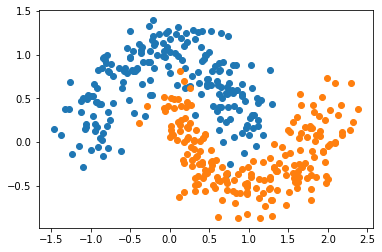

In [32]:
plt.scatter(X4[y4==0,0],X4[y4==0,1])
plt.scatter(X4[y4==1,0],X4[y4==1,1])

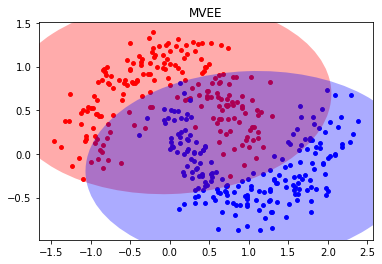

In [33]:
dataCellipses(X4,y4,'Moon Dataset')

The above plot shows that MVEE does not make any sense in this case as reducing the p value will lose the data samples.
So lets try to break there clusters into smaller clusters to see whether we can separate them well.

In [34]:
X4_trn,X4_tst,y4_trn,y4_tst = train_test_split(X4,y4,test_size=0.3,
                                               random_state=42,stratify=y4)

In [35]:
# Accuracies before clustering and denoising
lgr_X4 = LogisticRegression(max_iter=1000)
knn_X4 = KNeighborsClassifier(5)
svm_X4 = SVC(gamma=2,C=1)
rfc_X4 = RandomForestClassifier(max_depth=5,n_estimators=50,max_features=1)

lgr_X4.fit(X4_trn,y4_trn)
knn_X4.fit(X4_trn,y4_trn)
svm_X4.fit(X4_trn,y4_trn)
rfc_X4.fit(X4_trn,y4_trn)

RandomForestClassifier(max_depth=5, max_features=1, n_estimators=50)

In [36]:
lgr_X4.score(X4_tst,y4_tst)

0.875

In [37]:
knn_X4.score(X4_tst,y4_tst)

0.95

In [38]:
svm_X4.score(X4_tst,y4_tst)

0.95

In [39]:
rfc_X4.score(X4_tst,y4_tst)

0.9333333333333333

The above accuracies are the accuracies for before clustering and denoising.

## Clustering the dataset by Kmeans

In [40]:
Xc_0 = X4[y4==0]
yc_0 = y4[y4==0]
km_0 = KMeans(n_clusters=4,init='k-means++',n_init=10,
              max_iter=300,tol=1e-04,random_state=0)
y_km_0 = km_0.fit_predict(Xc_0)

Xc_1 = X4[y4==1]
yc_1 = y4[y4==1]
km_1 = KMeans(n_clusters=4,init='k-means++',n_init=10,
              max_iter=300,tol=1e-04,random_state=0)
y_km_1 = km_1.fit_predict(Xc_1)
y_km_1+=4

C:\Users\anupz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\anupz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [41]:
X4_clustered = np.vstack((Xc_0,Xc_1))
y4_clustered = np.hstack((y_km_0,y_km_1))

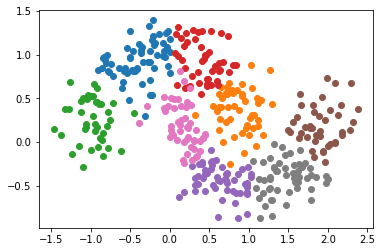

In [59]:
plt.scatter(X4_clustered[y4_clustered==0,0],X4_clustered[y4_clustered==0,1])
plt.scatter(X4_clustered[y4_clustered==1,0],X4_clustered[y4_clustered==1,1])
plt.scatter(X4_clustered[y4_clustered==2,0],X4_clustered[y4_clustered==2,1])
plt.scatter(X4_clustered[y4_clustered==3,0],X4_clustered[y4_clustered==3,1])
plt.scatter(X4_clustered[y4_clustered==4,0],X4_clustered[y4_clustered==4,1])
plt.scatter(X4_clustered[y4_clustered==5,0],X4_clustered[y4_clustered==5,1])
plt.scatter(X4_clustered[y4_clustered==6,0],X4_clustered[y4_clustered==6,1])
plt.scatter(X4_clustered[y4_clustered==7,0],X4_clustered[y4_clustered==7,1])
plt.show()

Here we can see that the dataset in broken down to 8 small clusters.

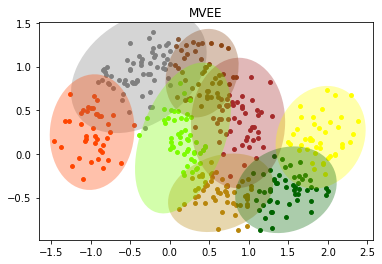

In [43]:
COLOR =['gray','brown','orangered','saddlebrown','darkgoldenrod',
        'yellow','lawngreen','darkgreen','cyan','magenta',
        'cornflowerblue','navy','blueviolet','deeppink','crimson']
dataCellipses(X4_clustered,y4_clustered,'clustered Moon dataset')

Here we have created smaller clusters . But we still see a lot of overlapping regions. Lets try to denoise the dataset.

In [44]:
X4_train,X4_test,y4_train,y4_test = train_test_split(X4_clustered,y4_clustered,
                                                     test_size=0.3,random_state=42,
                                                     stratify=y4_clustered)

In [45]:
X4_denoised_pca,y4_denoised_pca = denoise_by_pca(X4_train,y4_train,0.9)

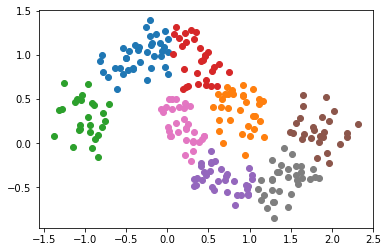

In [46]:
plt.scatter(X4_denoised_pca[y4_denoised_pca==0,0],X4_denoised_pca[y4_denoised_pca==0,1])
plt.scatter(X4_denoised_pca[y4_denoised_pca==1,0],X4_denoised_pca[y4_denoised_pca==1,1])
plt.scatter(X4_denoised_pca[y4_denoised_pca==2,0],X4_denoised_pca[y4_denoised_pca==2,1])
plt.scatter(X4_denoised_pca[y4_denoised_pca==3,0],X4_denoised_pca[y4_denoised_pca==3,1])
plt.scatter(X4_denoised_pca[y4_denoised_pca==4,0],X4_denoised_pca[y4_denoised_pca==4,1])
plt.scatter(X4_denoised_pca[y4_denoised_pca==5,0],X4_denoised_pca[y4_denoised_pca==5,1])
plt.scatter(X4_denoised_pca[y4_denoised_pca==6,0],X4_denoised_pca[y4_denoised_pca==6,1])
plt.scatter(X4_denoised_pca[y4_denoised_pca==7,0],X4_denoised_pca[y4_denoised_pca==7,1])

The above plot shows the clustered and denoised training data set. The clusters look well separated now.

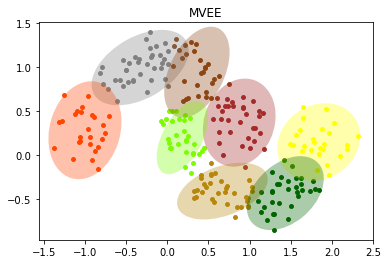

In [47]:
dataCellipses(X4_denoised_pca,y4_denoised_pca,'Moondata Denoised by pca')

Now we can see that the clusters are well separated by clustering and denoising. The overlapping of regions has reduced to very less.

In [48]:
p_values_moon = [0.5,0.6,0.7,0.8,0.9,0.95,0.99]
run_experiments(X4_clustered,y4_clustered,"Moon Data",classifiers,
                classifier_names,method='pca',parameters=p_values_moon)

For  Moon Data :-


Classifiers                             Before Denoising      pca-denoising p=  0.5
Logistic Regression                        0.91667               0.89167
KNeighbors classifier                      0.97500               0.95000
SVM                                        0.95833               0.92500
Random Forest                              0.90833               0.86667


Classifiers                             Before Denoising      pca-denoising p=  0.6
Logistic Regression                        0.91667               0.89167
KNeighbors classifier                      0.97500               0.91667
SVM                                        0.95833               0.92500
Random Forest                              0.90833               0.90000


Classifiers                             Before Denoising      pca-denoising p=  0.7
Logistic Regression                        0.91667               0.90000
KNeighbors classifier                      0.97500               0.

We can see that the accuracies have reduced slightly by clustering and denoising. Only in the case of Pca based denoising where p =0.9 and above , the accuracy has improved for RandomForest Classifier.

A general trend observed from the above results is that as the value of p gets closer to 1, the accuracies of the models are increasing. One reason for it might be because we keep adding more data which was important.

### Since the datasets we chose until now are already well trimmed datasets , it is possible that the improvement of the accuracy after denoising is not much. Lets try to add additional noise to the data to see if we can find any substantial improvemnt in the accuracy.

In [49]:
# Lets write a function to add more noise to dataset

def Perturb(X,sigma):
    rgen = np.random.RandomState(None)
    noise = rgen.normal(0,sigma,X.shape)
    X_p = X+noise
    
    return X_p

In [50]:
X1_Perturbed = Perturb(X1,0.8)

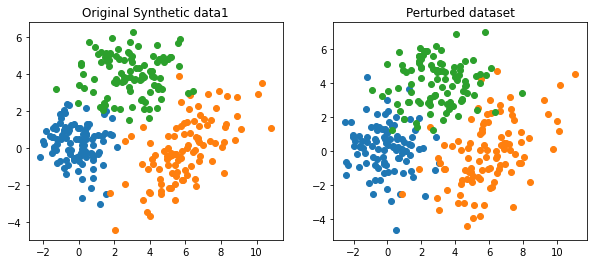

In [51]:

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))

    
ax[0].scatter(X1[y1==0,0],X1[y1==0,1])
ax[0].scatter(X1[y1==1,0],X1[y1==1,1])
ax[0].scatter(X1[y1==2,0],X1[y1==2,1])
ax[0].set_title('Original Synthetic data1')

ax[1].scatter(X1_Perturbed[y1==0,0],X1_Perturbed[y1==0,1])
ax[1].scatter(X1_Perturbed[y1==1,0],X1_Perturbed[y1==1,1])
ax[1].scatter(X1_Perturbed[y1==2,0],X1_Perturbed[y1==2,1])
ax[1].set_title('Perturbed dataset')

plt.show()

In [52]:
xi_values = [4,3]
run_experiments(X1_Perturbed,y1,'Perturbed Synthetic data',classifiers,
                classifier_names,method='knn',parameters=xi_values)

For  Perturbed Synthetic data :-


Classifiers                             Before Denoising      knn-denoising xi =4
Logistic Regression                        0.93333               0.93333
KNeighbors classifier                      0.93333               0.92222
SVM                                        0.84444               0.85556
Random Forest                              0.92222               0.91111


Classifiers                             Before Denoising      knn-denoising xi =3
Logistic Regression                        0.93333               0.92222
KNeighbors classifier                      0.93333               0.92222
SVM                                        0.84444               0.87778
Random Forest                              0.92222               0.90000




In [60]:
p_values = [0.75,0.9]
run_experiments(X1_Perturbed,y1,'Perturbed Synthetic data',classifiers,
                classifier_names,method='pca',parameters=p_values)

For  Perturbed Synthetic data :-


Classifiers                             Before Denoising      pca-denoising p=  0.75
Logistic Regression                        0.93333               0.93333
KNeighbors classifier                      0.93333               0.92222
SVM                                        0.84444               0.88889
Random Forest                              0.92222               0.92222


Classifiers                             Before Denoising      pca-denoising p=  0.9
Logistic Regression                        0.93333               0.91111
KNeighbors classifier                      0.93333               0.92222
SVM                                        0.84444               0.86667
Random Forest                              0.92222               0.87778




For the Synthetic data set, we can see that the improvemnt in accuracy is shown in the case of SVM. Other classifier accuracies have remained same or slighly reduced.

In [54]:
X2_Perturbed = Perturb(X2,0.2)

In [55]:
xi_values = [4,3]
run_experiments(X2_Perturbed,y2,'Perturbed Iris data',classifiers,
                classifier_names,method='knn',parameters=xi_values)

For  Perturbed Iris data :-


Classifiers                             Before Denoising      knn-denoising xi =4
Logistic Regression                        0.86667               0.86667
KNeighbors classifier                      0.88889               0.91111
SVM                                        0.86667               0.86667
Random Forest                              0.86667               0.88889


Classifiers                             Before Denoising      knn-denoising xi =3
Logistic Regression                        0.86667               0.88889
KNeighbors classifier                      0.88889               0.91111
SVM                                        0.86667               0.86667
Random Forest                              0.86667               0.88889




In [56]:
p_values = [0.75,0.9]
run_experiments(X2_Perturbed,y2,'Perturbed Iris data',classifiers,
                classifier_names,method='pca',parameters=p_values)

For  Perturbed Iris data :-


Classifiers                             Before Denoising      pca-denoising p=  0.75
Logistic Regression                        0.86667               0.86667
KNeighbors classifier                      0.88889               0.91111
SVM                                        0.86667               0.86667
Random Forest                              0.84444               0.88889


Classifiers                             Before Denoising      pca-denoising p=  0.9
Logistic Regression                        0.86667               0.88889
KNeighbors classifier                      0.88889               0.88889
SVM                                        0.86667               0.86667
Random Forest                              0.84444               0.84444




For Iris Dataset, we can see better improvement in accuracies in almost all classifiers.

### Thus, we can say that denoising makes the data shape better by separating the clusters well and improving the accuracies slightly.